# 19. SHAP 分析（滑動視窗資料）

## 與 Notebook 08 的差異
- **資料**：使用滑動視窗資料集（13,514 筆樣本）
- **特徵**：Tinput1、Tinput2、Delta_ 格式
- **備註**：此分析取代 08_SHAP_Analysis，作為論文最終結果

## 日期：2026-01-13

In [15]:
# 匯入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

import shap
shap.initjs()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'DejaVu Sans', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

print(f"SHAP 版本: {shap.__version__}")

SHAP 版本: 0.42.1


## 1. 載入滑動視窗資料

In [16]:
# 載入滑動視窗資料
df = pd.read_csv('../../data/01_primary/SUA/processed/SUA_sliding_window.csv')
print(f"資料載入完成：{len(df):,} 筆樣本，來自 {df['patient_id'].nunique():,} 位患者")
print(f"\n欄位：{list(df.columns)}")

資料載入完成：13,514 筆樣本，來自 6,056 位患者

欄位：['patient_id', 'window_start', 'window_id', 'sex', 'Age', 'FBG_Tinput1', 'TC_Tinput1', 'Cr_Tinput1', 'UA_Tinput1', 'GFR_Tinput1', 'BMI_Tinput1', 'SBP_Tinput1', 'DBP_Tinput1', 'FBG_Tinput2', 'TC_Tinput2', 'Cr_Tinput2', 'UA_Tinput2', 'GFR_Tinput2', 'BMI_Tinput2', 'SBP_Tinput2', 'DBP_Tinput2', 'Delta_FBG', 'Delta_TC', 'Delta_Cr', 'Delta_UA', 'Delta_GFR', 'Delta_BMI', 'Delta_SBP', 'Delta_DBP', 'hypertension_target', 'hyperglycemia_target', 'dyslipidemia_target']


In [17]:
# 定義特徵
feature_cols = [
    'sex', 'Age',
    # Y-2 時間點特徵
    'FBG_Tinput1', 'TC_Tinput1', 'Cr_Tinput1', 'UA_Tinput1', 'GFR_Tinput1', 'BMI_Tinput1', 'SBP_Tinput1', 'DBP_Tinput1',
    # Y-1 時間點特徵
    'FBG_Tinput2', 'TC_Tinput2', 'Cr_Tinput2', 'UA_Tinput2', 'GFR_Tinput2', 'BMI_Tinput2', 'SBP_Tinput2', 'DBP_Tinput2',
    # Δ 變化量特徵
    'Delta_FBG', 'Delta_TC', 'Delta_Cr', 'Delta_UA', 'Delta_GFR', 'Delta_BMI', 'Delta_SBP', 'Delta_DBP'
]

X = df[feature_cols]

# 目標變數（將 1/2 轉換為 0/1）
targets = {
    '高血壓': (df['hypertension_target'] == 2).astype(int),
    '高血糖': (df['hyperglycemia_target'] == 2).astype(int),
    '高血脂': (df['dyslipidemia_target'] == 2).astype(int)
}

print(f"特徵數：{len(feature_cols)}")
print(f"\n類別分佈：")
for name, y in targets.items():
    print(f"  {name}：{y.mean()*100:.2f}% 陽性")

特徵數：26

類別分佈：
  高血壓：19.29% 陽性
  高血糖：5.93% 陽性
  高血脂：7.94% 陽性


## 2. 訓練模型

In [18]:
# 訓練集/測試集分割（以高血壓作為分層依據）
X_train, X_test, y_train_dict, y_test_dict = {}, {}, {}, {}

# 統一分割，套用至所有目標變數
train_idx, test_idx = train_test_split(
    df.index, test_size=0.2, random_state=42, 
    stratify=targets['高血壓']
)

X_train = X.loc[train_idx]
X_test = X.loc[test_idx]

for name, y in targets.items():
    y_train_dict[name] = y.loc[train_idx]
    y_test_dict[name] = y.loc[test_idx]

# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 論文用顯示標籤（Tinput1→Y-2, Tinput2→Y-1, Delta_→Δ）
display_cols = []
for col in feature_cols:
    if 'Tinput1' in col:
        display_cols.append(col.replace('_Tinput1', '_Y-2'))
    elif 'Tinput2' in col:
        display_cols.append(col.replace('_Tinput2', '_Y-1'))
    elif col.startswith('Delta_'):
        display_cols.append('Δ' + col[6:])
    else:
        display_cols.append(col)

# 轉回 DataFrame 以供 SHAP 使用（使用論文標籤）
X_train_df = pd.DataFrame(X_train_scaled, columns=display_cols, index=X_train.index)
X_test_df = pd.DataFrame(X_test_scaled, columns=display_cols, index=X_test.index)

print(f"訓練集：{len(X_train):,} 筆樣本")
print(f"測試集：{len(X_test):,} 筆樣本")
print(f"\n特徵標籤範例：{display_cols[:6]}...")

訓練集：10,811 筆樣本
測試集：2,703 筆樣本

特徵標籤範例：['sex', 'Age', 'FBG_Y-2', 'TC_Y-2', 'Cr_Y-2', 'UA_Y-2']...


In [19]:
# 訓練 XGBoost 模型
xgb_models = {}

print("=" * 60)
print("訓練 XGBoost 模型")
print("=" * 60)

for disease in targets.keys():
    y_train = y_train_dict[disease]
    y_test = y_test_dict[disease]
    
    # 計算 scale_pos_weight
    spw = (y_train == 0).sum() / (y_train == 1).sum()
    
    model = XGBClassifier(
        scale_pos_weight=spw,
        max_depth=5,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42,
        eval_metric='logloss',
        verbosity=0
    )
    model.fit(X_train_scaled, y_train)
    
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    
    xgb_models[disease] = model
    print(f"{disease}：AUC = {auc:.3f}")

訓練 XGBoost 模型
高血壓：AUC = 0.737
高血糖：AUC = 0.924
高血脂：AUC = 0.838


## 3. SHAP 分析 - 三種疾病

In [20]:
# 計算所有疾病的 SHAP 值
shap_values_dict = {}
explainer_dict = {}

for disease, model in xgb_models.items():
    print(f"計算 {disease} 的 SHAP 值...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_df)
    
    explainer_dict[disease] = explainer
    shap_values_dict[disease] = shap_values
    print(f"  完成。形狀：{shap_values.shape}")

print("\n所有 SHAP 值計算完成。")

計算 高血壓 的 SHAP 值...
  完成。形狀：(2703, 26)
計算 高血糖 的 SHAP 值...
  完成。形狀：(2703, 26)
計算 高血脂 的 SHAP 值...
  完成。形狀：(2703, 26)

所有 SHAP 值計算完成。


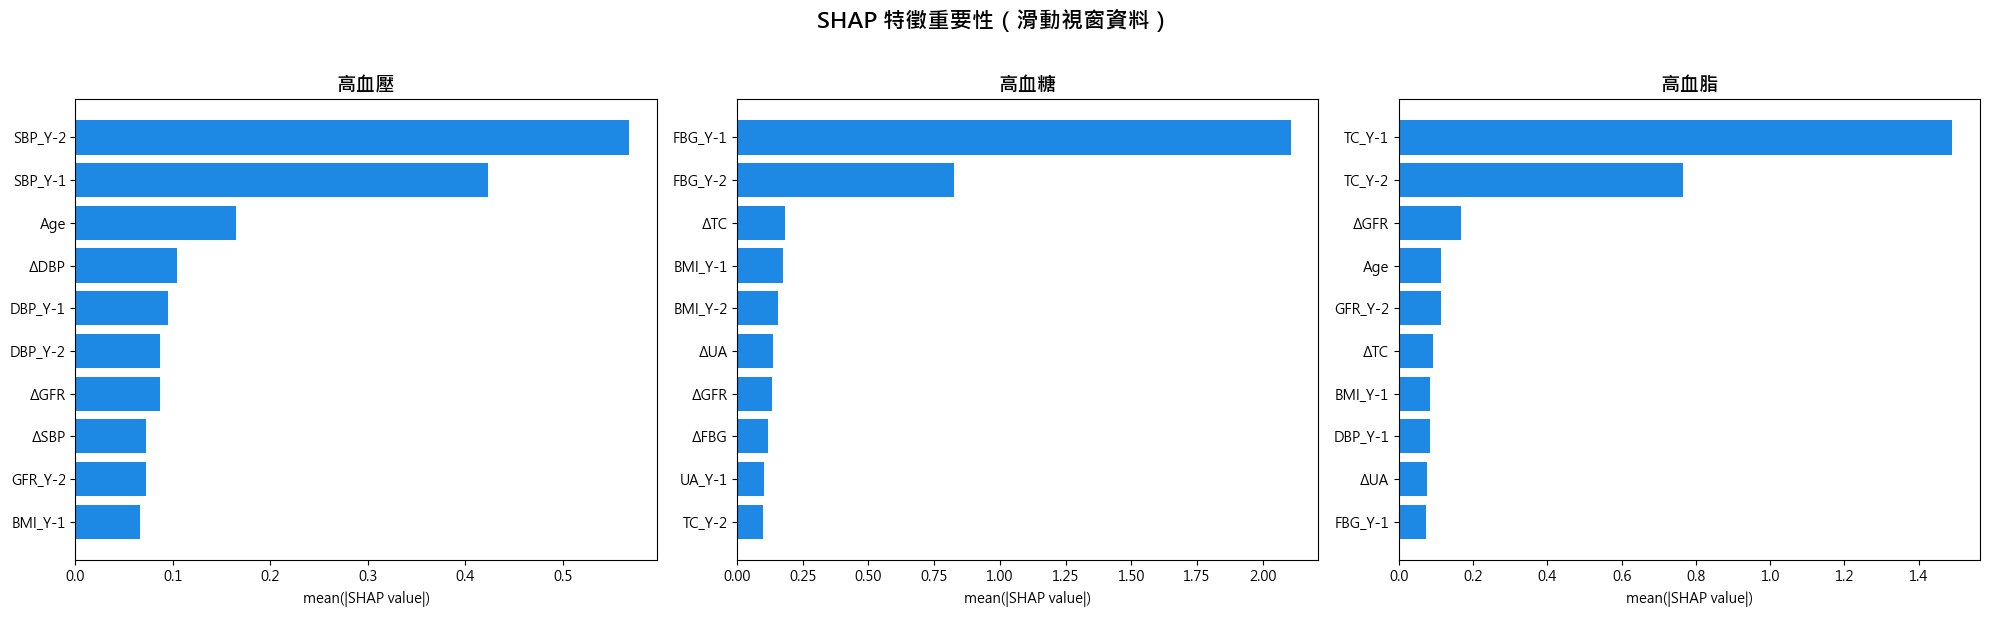

已儲存：results/shap_sliding_window_importance.png
已儲存：docs/00_thesis/figures/fig4-2_shap_comparison.png


In [21]:
# 各疾病的 SHAP 特徵重要性摘要圖（水平排列）
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (disease, shap_vals) in enumerate(shap_values_dict.items()):
    mean_abs = np.abs(shap_vals).mean(axis=0)
    sorted_idx = np.argsort(mean_abs)[-10:]  # Top 10
    
    axes[idx].barh(range(len(sorted_idx)), mean_abs[sorted_idx], color='#1E88E5')
    axes[idx].set_yticks(range(len(sorted_idx)))
    axes[idx].set_yticklabels([display_cols[i] for i in sorted_idx])
    axes[idx].set_xlabel('mean(|SHAP value|)')
    axes[idx].set_title(disease, fontsize=14, fontweight='bold')

plt.suptitle('SHAP 特徵重要性（滑動視窗資料）', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../../results/shap_sliding_window_importance.png', dpi=150, bbox_inches='tight')
plt.savefig('../../docs/00_thesis/figures/fig4-2_shap_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("已儲存：results/shap_sliding_window_importance.png")
print("已儲存：docs/00_thesis/figures/fig4-2_shap_comparison.png")

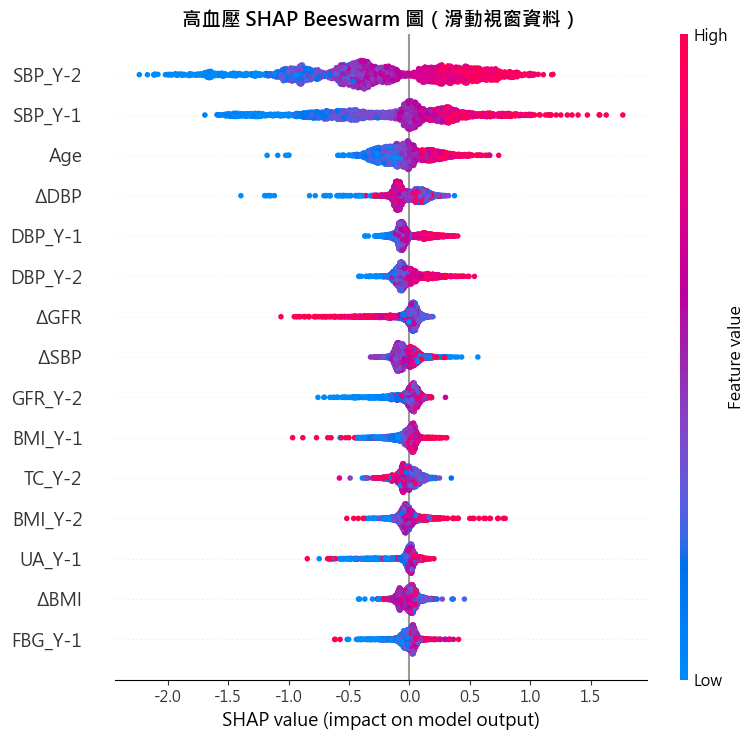

已儲存：results/shap_sliding_window_beeswarm.png
已儲存：docs/00_thesis/figures/fig4-3_shap_beeswarm.png


In [22]:
# Beeswarm 圖（高血壓）
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_dict['高血壓'], X_test_df, show=False, max_display=15)
plt.title('高血壓 SHAP Beeswarm 圖（滑動視窗資料）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../../results/shap_sliding_window_beeswarm.png', dpi=150, bbox_inches='tight')
plt.savefig('../../docs/00_thesis/figures/fig4-3_shap_beeswarm.png', dpi=150, bbox_inches='tight')
plt.show()
print("已儲存：results/shap_sliding_window_beeswarm.png")
print("已儲存：docs/00_thesis/figures/fig4-3_shap_beeswarm.png")

## 4. 特徵重要性比較

In [23]:
# 計算各疾病的平均 |SHAP| 值
importance_df = pd.DataFrame({'Feature': display_cols})

for disease, shap_values in shap_values_dict.items():
    importance_df[disease] = np.abs(shap_values).mean(axis=0)

# 依高血壓重要性排序
importance_df = importance_df.sort_values('高血壓', ascending=False)

print("=" * 80)
print("SHAP 特徵重要性（Top 15）")
print("=" * 80)
print(importance_df.head(15).to_string(index=False))

SHAP 特徵重要性（Top 15）
Feature      高血壓      高血糖      高血脂
SBP_Y-2 0.567909 0.072020 0.036479
SBP_Y-1 0.423229 0.057124 0.050803
    Age 0.164311 0.078177 0.113088
   ΔDBP 0.103863 0.057885 0.058843
DBP_Y-1 0.094734 0.060096 0.083282
DBP_Y-2 0.087149 0.071184 0.054830
   ΔGFR 0.086896 0.132986 0.168356
   ΔSBP 0.072473 0.070714 0.046948
GFR_Y-2 0.071919 0.090389 0.112577
BMI_Y-1 0.066085 0.172809 0.084652
 TC_Y-2 0.063403 0.097826 0.765531
BMI_Y-2 0.063230 0.155641 0.053953
 UA_Y-1 0.057319 0.102772 0.042942
   ΔBMI 0.053187 0.087077 0.069031
FBG_Y-1 0.051233 2.107033 0.072810


In [24]:
# 特徵分類（使用論文標籤）
def categorize_feature(name):
    if name in ['sex', 'Age']:
        return '人口學特徵'
    elif 'Y-2' in name:
        return 'Y-2 時間點'
    elif 'Y-1' in name:
        return 'Y-1 時間點'
    elif name.startswith('Δ'):
        return 'Δ 變化量'
    return '其他'

importance_df['類別'] = importance_df['Feature'].apply(categorize_feature)

# 依類別彙整
category_importance = importance_df.groupby('類別')[['高血壓', '高血糖', '高血脂']].sum()

print("\n" + "=" * 60)
print("特徵類別重要性彙整")
print("=" * 60)
print(category_importance)


特徵類別重要性彙整
              高血壓       高血糖       高血脂
類別                                   
Y-1 時間點  0.775889  2.703867  1.937564
Y-2 時間點  0.967221  1.428036  1.149075
Δ 變化量    0.431630  0.823589  0.611580
人口學特徵    0.168759  0.082612  0.157010


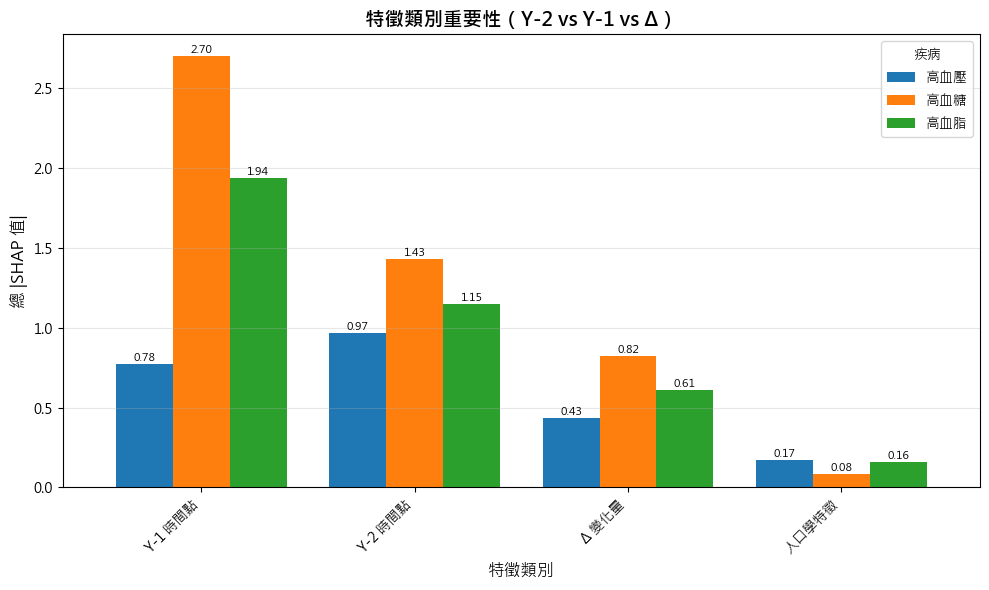

已儲存：results/shap_sliding_window_category.png


In [25]:
# 視覺化：特徵類別重要性
fig, ax = plt.subplots(figsize=(10, 6))

category_importance.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('特徵類別', fontsize=12)
ax.set_ylabel('總 |SHAP 值|', fontsize=12)
ax.set_title('特徵類別重要性（Y-2 vs Y-1 vs Δ）', fontsize=14, fontweight='bold')
ax.legend(title='疾病', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8)

plt.tight_layout()
plt.savefig('../../results/shap_sliding_window_category.png', dpi=150, bbox_inches='tight')
plt.show()
print("已儲存：results/shap_sliding_window_category.png")

In [26]:
# 儲存完整結果
importance_df.to_csv('../../results/shap_sliding_window_importance.csv', index=False)
print("已儲存：results/shap_sliding_window_importance.csv")

# 摘要
print("\n" + "=" * 80)
print("摘要")
print("=" * 80)
print(f"""
資料：
  - 樣本數：{len(df):,}（滑動視窗）
  - 患者數：{df['patient_id'].nunique():,}
  - 特徵數：{len(feature_cols)}

各疾病 Top 3 重要特徵：
""")

for disease in ['高血壓', '高血糖', '高血脂']:
    top3 = importance_df.nlargest(3, disease)[['Feature', disease]]
    print(f"  {disease}：")
    for _, row in top3.iterrows():
        print(f"    - {row['Feature']}: {row[disease]:.3f}")

已儲存：results/shap_sliding_window_importance.csv

摘要

資料：
  - 樣本數：13,514（滑動視窗）
  - 患者數：6,056
  - 特徵數：26

各疾病 Top 3 重要特徵：

  高血壓：
    - SBP_Y-2: 0.568
    - SBP_Y-1: 0.423
    - Age: 0.164
  高血糖：
    - FBG_Y-1: 2.107
    - FBG_Y-2: 0.825
    - ΔTC: 0.182
  高血脂：
    - TC_Y-1: 1.490
    - TC_Y-2: 0.766
    - ΔGFR: 0.168


## 5. 結論

本 notebook 使用滑動視窗資料集（13,514 筆樣本）進行 SHAP 分析。

主要發現將與原始 08_SHAP_Analysis 結果進行比較，以驗證一致性。